# Objective

The objective is to cluster the similar spot instances together. Thus, when the user needs to get another spot instance, he can select one from a pool where the price changes and update intervals are similar.

# Code

## Load libs

In [1]:
import sys
sys.path.append('..')

import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Input params

In [2]:
compression = 'zip'

models_dir = '../models'
processed_dir = '../data/processed'

in_fname_pricing = 'step_5_features_pricing_var.csv.zip'
in_fname_updist = 'step_5_features_updist.csv.zip'

out_fname = 'step_7_clustered_features.csv.zip'

In [3]:
# Papermill parameters injection ... do not delete!

## Load data

In [4]:
# Pricing info
file = f'{processed_dir}/{in_fname_pricing}'
pricing_df = pd.read_csv(file, 
                   compression='zip', 
                   index_col=0)\
               .T\
               .add_prefix('price_')

print(pricing_df.shape)
pricing_df.head()

(331, 9)


,price_count,price_mean,price_std,price_min,price_25%,price_50%,price_75%,price_max,price_price_var
a1.2xlarge,31.0,0.067,0.000,0.067,0.067,0.067,0.067,0.067,0.0
a1.4xlarge,30.0,0.134,0.000,0.134,0.134,0.134,0.134,0.134,0.0
a1.large,63.0,0.022,0.001,0.020,0.021,0.022,0.022,0.023,0.0
a1.medium,31.0,0.008,0.000,0.008,0.008,0.008,0.008,0.008,0.0
a1.metal,33.0,0.134,0.000,0.134,0.134,0.134,0.134,0.134,0.0


In [5]:
# Update distribution info
file = f'{processed_dir}/{in_fname_updist}'
updist_df = pd.read_csv(file, 
                        compression=compression, 
                        index_col=0)\
              .T\
              .add_prefix('updist_')

print(updist_df.shape)
updist_df.head()

(230, 7)


,updist_mean,updist_std,updist_min,updist_25%,updist_50%,updist_75%,updist_max
a1.large,48002.215686,34996.722451,17637.0,24173.0,40816.0,57136.50,207049.0
c1.xlarge,23118.774854,5713.610456,11821.0,19163.0,22421.0,25161.75,45531.0
c3.2xlarge,23718.355769,6900.502253,16564.0,19655.0,23159.5,25578.50,54365.0
c3.4xlarge,23279.242991,6876.125450,16493.0,19383.5,22198.0,24936.50,58437.0
c3.8xlarge,22547.162162,5310.423968,16623.0,19635.5,21681.0,24207.50,46775.0


In [6]:
# Perform a inner join with the updist df
# Results in a feature df
fdf = updist_df.join(pricing_df)
fdf.head()

,updist_mean,updist_std,updist_min,updist_25%,updist_50%,updist_75%,updist_max,price_count,price_mean,price_std,price_min,price_25%,price_50%,price_75%,price_max,price_price_var
a1.large,48002.215686,34996.722451,17637.0,24173.0,40816.0,57136.50,207049.0,63.0,0.022,0.001,0.020,0.021,0.022,0.022,0.023,0.000
c1.xlarge,23118.774854,5713.610456,11821.0,19163.0,22421.0,25161.75,45531.0,357.0,0.140,0.045,0.074,0.110,0.130,0.154,0.289,0.002
c3.2xlarge,23718.355769,6900.502253,16564.0,19655.0,23159.5,25578.50,54365.0,111.0,0.142,0.003,0.137,0.141,0.142,0.143,0.149,0.000
c3.4xlarge,23279.242991,6876.125450,16493.0,19383.5,22198.0,24936.50,58437.0,114.0,0.298,0.014,0.272,0.284,0.300,0.310,0.318,0.000
c3.8xlarge,22547.162162,5310.423968,16623.0,19635.5,21681.0,24207.50,46775.0,114.0,0.494,0.009,0.475,0.490,0.496,0.499,0.509,0.000


## Data normalization

We need to normalize the data as they are in different scales and it may bias the clustering algorithm towards bigger numbers.

In [7]:
scaler = StandardScaler()
scaled_fdf = scaler.fit_transform(fdf)
print(scaled_fdf)

[[-0.19202697 -0.40516678  0.08328326 ... -0.79126369 -0.63691439
  -0.16950135]
 [-0.31181038 -0.4771232  -0.08727382 ... -0.63203755 -0.43085841
  -0.16544186]
 [-0.30892413 -0.47420669  0.051817   ... -0.6453064  -0.53930892
  -0.16950135]
 ...
 [ 0.95339529  1.83625958 -0.17633535 ... -0.00960811 -0.10705615
  -0.16950135]
 [-0.07824089  0.22819245  0.05301935 ... -0.70200055 -0.54628074
  -0.1674716 ]
 [-0.23505329 -0.11275308 -0.32656986 ... -0.6453064  -0.53078781
  -0.16950135]]


In [8]:
pd.DataFrame(scaled_fdf)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.192027,-0.405167,0.083283,-0.064870,0.039395,-0.032323,-0.568487,-1.493622,-0.816331,-0.343615,-0.837460,-0.868920,-0.816701,-0.791264,-0.636914,-0.169501
1,-0.311810,-0.477123,-0.087274,-0.154215,-0.160686,-0.153069,-0.668966,1.192085,-0.657939,-0.182483,-0.748290,-0.725112,-0.665744,-0.632038,-0.430858,-0.165442
2,-0.308924,-0.474207,0.051817,-0.145441,-0.152653,-0.151495,-0.663470,-1.055139,-0.655254,-0.336291,-0.644259,-0.675021,-0.648971,-0.645306,-0.539309,-0.169501
3,-0.311038,-0.474267,0.049735,-0.150283,-0.163111,-0.153920,-0.660937,-1.027734,-0.445855,-0.296008,-0.421336,-0.443958,-0.428126,-0.443861,-0.408394,-0.169501
4,-0.314562,-0.478114,0.053547,-0.145789,-0.168735,-0.156673,-0.668192,-1.027734,-0.182763,-0.314318,-0.086125,-0.111098,-0.154166,-0.215878,-0.260436,-0.169501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,-0.279922,-0.228461,-0.225133,-0.151491,-0.162954,-0.153035,0.399081,0.634847,-0.512970,-0.244739,-0.502249,-0.534444,-0.520378,-0.484874,-0.409168,-0.167472
226,0.287350,0.765779,-0.404136,-0.180841,-0.191261,-0.152928,0.628677,-1.046004,-0.394847,-0.336291,-0.317305,-0.361551,-0.379204,-0.413705,-0.385154,-0.169501
227,0.953395,1.836260,-0.176335,-0.139222,-0.155024,-0.153009,1.938100,-0.982058,0.057509,-0.310656,0.235875,0.179750,0.089043,-0.009608,-0.107056,-0.169501
228,-0.078241,0.228192,0.053019,-0.145259,-0.158065,-0.151049,1.003649,-0.406550,-0.742504,-0.259387,-0.778014,-0.812366,-0.752405,-0.702001,-0.546281,-0.167472


In [9]:
inertia = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state=42)
    kmeans.fit(scaled_fdf)
    inertia.append(kmeans.inertia_)

Text(0.5, 1.0, 'Number of cluster when it becomes linear = 13')

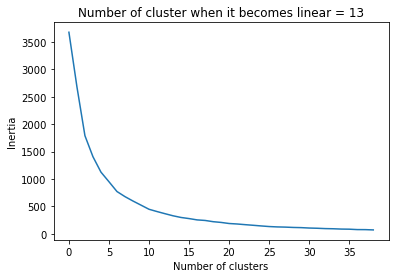

In [10]:
plt.plot(inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Number of cluster when it becomes linear = 13')

In [11]:
kmeans = KMeans(n_clusters = 13, init='k-means++', random_state=42)
kmeans.fit(scaled_fdf)
cluster_num = kmeans.predict(scaled_fdf)
cluster_num

array([ 1,  9,  1,  1, 12, 11,  1,  9,  9,  4,  9,  9,  4,  4,  0,  9,  9,
        4,  1,  0,  9, 10, 12,  0, 10,  1, 12, 10, 10, 12,  4,  0,  9,  9,
        4,  9,  9,  9,  4,  1,  7,  9, 12, 12,  1,  1, 12, 10, 10,  0, 10,
        0,  8, 12,  4,  7, 10,  7,  1,  1,  0,  9,  9, 12,  9,  0,  9, 12,
       10,  5,  9,  6, 12, 10, 10, 10,  9,  1,  4,  4,  9,  9,  9,  9,  4,
        4,  0,  9,  9,  9,  1,  0,  9,  4,  4,  0,  9,  9,  4,  9,  9,  4,
        0,  9,  9,  1,  9, 12,  4,  7,  9,  9,  4,  1,  7,  9,  4,  0,  0,
        9,  9,  4,  1,  9,  4,  4,  9,  9,  4,  9,  9, 10,  7, 10,  0,  0,
        1, 12, 12,  1,  4,  9,  9, 12,  9,  9,  4,  4,  0,  9,  9,  4,  1,
        0,  9,  4,  0,  0,  9,  9,  4,  1,  9,  4,  0,  6,  9,  9,  1,  9,
        4,  4,  0,  9,  9,  4,  1,  0,  9,  0,  2,  6,  9, 12, 12,  1,  9,
        4,  4,  7,  9,  9,  4,  9,  1, 12, 12,  1,  1, 12,  1,  1,  7,  1,
        1,  1,  0, 10,  9,  9,  1, 10,  1,  1,  3, 10,  1,  1,  1, 10,  1,
        1,  1,  1,  7,  9

In [12]:
with open(f"{models_dir}/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [13]:
fdf['cluster_num'] = cluster_num
fdf.head()

,updist_mean,updist_std,updist_min,updist_25%,updist_50%,updist_75%,updist_max,price_count,price_mean,price_std,price_min,price_25%,price_50%,price_75%,price_max,price_price_var,cluster_num
a1.large,48002.215686,34996.722451,17637.0,24173.0,40816.0,57136.50,207049.0,63.0,0.022,0.001,0.020,0.021,0.022,0.022,0.023,0.000,1
c1.xlarge,23118.774854,5713.610456,11821.0,19163.0,22421.0,25161.75,45531.0,357.0,0.140,0.045,0.074,0.110,0.130,0.154,0.289,0.002,9
c3.2xlarge,23718.355769,6900.502253,16564.0,19655.0,23159.5,25578.50,54365.0,111.0,0.142,0.003,0.137,0.141,0.142,0.143,0.149,0.000,1
c3.4xlarge,23279.242991,6876.125450,16493.0,19383.5,22198.0,24936.50,58437.0,114.0,0.298,0.014,0.272,0.284,0.300,0.310,0.318,0.000,1
c3.8xlarge,22547.162162,5310.423968,16623.0,19635.5,21681.0,24207.50,46775.0,114.0,0.494,0.009,0.475,0.490,0.496,0.499,0.509,0.000,12


In [14]:
fdf.to_csv(f'{processed_dir}/{out_fname}', compression=compression)